In [4]:

# coding: utf-8

# In[105]:


from pypokerengine.utils.game_state_utils import restore_game_state, attach_hole_card, attach_hole_card_from_deck
from pypokerengine.players import BasePokerPlayer
from pypokerengine.api.emulator import Emulator
from pypokerengine.engine.card import Card
from pypokerengine.utils.card_utils import estimate_hole_card_win_rate, gen_cards
from pypokerengine.engine.poker_constants import PokerConstants as Const
from pypokerengine.engine.hand_evaluator import HandEvaluator
from My_utils import hand_strength_with_belief, hand_strength, win_rate
import itertools
import numpy as np
from time import time,sleep
import pprint


# In[ ]:
PREFLOP_HAND_STRENGTH = np.load('preflop_hand_strength.npy').item()

def get_hand_strength(hole, community_card):
    hole = gen_cards(hole)
    community_card = gen_cards(community_card)
    cards = [x.rank for x in hole] + [x.rank for x in community_card]
    num_community_card = len(community_card)
    if num_community_card == 0:
        for i in range(len(PREFLOP_HAND_STRENGTH['card'])):
            if set(cards) == set(PREFLOP_HAND_STRENGTH['card'][i]):
                return PREFLOP_HAND_STRENGTH['strength'][i]

    if num_community_card == 3:
        for i in range(len(FLOP_HAND_STRENGTH['card'])):
            if set(cards) == set(FLOP_HAND_STRENGTH['card'][i]):
                return FLOP_HAND_STRENGTH['strength'][i]

    if num_community_card == 4:
        for i in range(len(TURN_HAND_STRENGTH['card'])):
            if set(cards) == set(TURN_HAND_STRENGTH['card'][i]):
                return TURN_HAND_STRENGTH['strength'][i]

    if num_community_card == 5:
        for i in range(len(RIVER_HAND_STRENGTH['card'])):
            if set(cards) == set(RIVER_HAND_STRENGTH['card'][i]):
                return RIVER_HAND_STRENGTH['strength'][i]

    return hand_strength(hole, community_card)

emulator = Emulator()
emulator.set_game_rule(2,1,10,0)



# In[115]:


# heuristic_weights for[HC,LP,MP,HP,2P,3C,Straight,flush,FH,4C,SF]
heuristic_weights =  np.array([0.1,1,2,3,7,14,28,56,112,224,448])
heuristic_weights = heuristic_weights/np.sum(heuristic_weights)
# print(heuristic_weights)
#quantiles = [1,8,20]
QUANTILE = [0.2,0.3,0.5,0.8]

def heuristic1(hole, community_card, heuristic_weights=heuristic_weights):
    cards = hole + community_card
    score_vector = np.zeros(11)
    if HandEvaluator._HandEvaluator__is_straightflash(cards): score_vector[10]=0
    if HandEvaluator._HandEvaluator__is_fourcard(cards): score_vector[9]=1
    if HandEvaluator._HandEvaluator__is_fullhouse(cards): score_vector[8]=1
    if HandEvaluator._HandEvaluator__is_flash(cards): score_vector[7]=0
    if HandEvaluator._HandEvaluator__is_straight(cards): score_vector[6]=1
    if HandEvaluator._HandEvaluator__is_threecard(cards): score_vector[5]=1
    if HandEvaluator._HandEvaluator__is_twopair(cards): score_vector[4]=1
    if HandEvaluator._HandEvaluator__is_onepair(cards): 
        if cards[0].rank >=10:
            score_vector[3]=1
        elif cards[0].rank >=6:
            score_vector[2]=1
        else:
            score_vector[1]=1
            
    if cards and max(list(map(lambda x: x.rank,cards))) >=11:
        score_vector[0]=1
    return np.dot(heuristic_weights,score_vector)

def sigmoid(z):
    return 10000./(1+np.exp(-z))

# heuristic = heuristic1 
heuristic = hand_strength

def setup_game_state(round_state, my_hole_cards, my_uuid, opponent_hole_cards = []):
    game_state = restore_game_state(round_state)
    for player_info in round_state['seats']:
        uuid = player_info['uuid']
        if uuid == my_uuid:
            game_state = attach_hole_card(game_state, uuid, my_hole_cards)
        else:
            if not opponent_hole_cards:
                game_state = attach_hole_card_from_deck(game_state, uuid)
            else:
                game_state = attach_hole_card(game_state, uuid, opponent_hole_cards)
    return game_state

# In[116]:

class Advisor():
    def __init__(self, hole_card, my_uuid, weight):

        self.weight = weight
        self.round_state = None
        self.pay_off_table = {}
        
        self.my_uuid = my_uuid
        self.my_card = gen_cards(hole_card)
        self.my_current_cost = 10
#         self.my_belief = self.init_my_belief()
        self.opp_statistics = {'raise': 0, 'call': 0, 'fold': 0}

#         self.opp_belief = self.init_opp_belief()
        
    def update_my_belief(self, action):
        pass
    
    def update_round_state(self,round_state):
        self.round_state = round_state
        
        if round_state['seats'][round_state['big_blind_pos']]['uuid']==self.my_uuid and self.my_current_cost ==0:
            self.my_current_cost = 20
        else: 
            self.my_current_cost = 10
            
        ## Update opp_statistics
        prev_street = {'flop': 'preflop', 'turn':'flop', 'river': 'turn'}
        histories = self.round_state['action_histories']
        if histories.get(self.round_state['street']):
            prev_opp_action = histories[self.round_state['street']][-1]['action'].lower()
            if self.opp_statistics.get(prev_opp_action) != None:
                self.opp_statistics[prev_opp_action] += 1
        elif prev_street.get(self.round_state['street']):
            prev_opp_action = histories[prev_street.get(self.round_state['street'])][-1]['action'].lower()
            self.opp_statistics[prev_opp_action] += 1

    def init_my_belief(self):
        unsuit_rank = list(itertools.combinations_with_replacement(range(2,15),2))
        unsuit_card = np.array(list(map(lambda x: AbstractHoleCard([x[0],x[1]]),unsuit_rank)))
        probability = np.ones(91) 
        for i in range(len(unsuit_card)):
            hand = unsuit_card[i]
            if(hand.ranks[0]==hand.ranks[1]):
                probability[i] = float(6)/1325
            else:
                probability[i] = float(16)/1325
        strength = np.array(list(map(lambda x: heuristic(x.to_hole_card(),[]),unsuit_card)))
        sort_indices = np.argsort(strength)
        return { 'card':unsuit_card[sort_indices],
                  'strength':strength[sort_indices],
                  'probability':probability[sort_indices]
                }

    def init_opp_belief(self):
        unsuit_rank = list(itertools.combinations_with_replacement(range(2,15),2))
        unsuit_card = np.array(list(map(lambda x: AbstractHoleCard([x[0],x[1]]),unsuit_rank)))
        probability = np.zeros(91) 
        for i in range(len(unsuit_card)):
            hand = unsuit_card[i]
            if(hand.ranks[0]==hand.ranks[1]):
                probability[i] = float(6)/1325
            else:
                probability[i] = float(16)/1325
        strength = np.array(list(map(lambda x: heuristic1(x.to_hole_card(),[]),unsuit_card)))
        sort_indices = np.argsort(strength)
        return  { 'card'        :   unsuit_card[sort_indices],
                  'strength'    :   strength[sort_indices],
                  'probability' :   probability[sort_indices]
                }

    def get_bucket(self):
        bucketed_cards = {'card':[], 'strength':[], 'probability': []}
        quantiles = QUANTILE
        # print(self.my_belief['strength'])
        quantile_values = list(map(lambda x: np.quantile(self.my_belief['strength'], x), quantiles))
        
        for i in range(len(quantile_values) + 1):
            if i == 0:
                curr_q = quantile_values[i]
                indices = np.where(self.my_belief['strength'] <= quantile_values[i])[0]
            elif i == len(quantile_values):
                indices = np.where(self.my_belief['strength'] > curr_q)[0]
            else:
                indices = np.where((self.my_belief['strength'] > curr_q) & (self.my_belief['strength'] <= quantile_values[i]))[0]
                curr_q = quantile_values[i]
            
            if len(indices) == 0:
                continue
            bucketed_cards['card'] += [self.my_belief['card'][indices][len(indices) // 2]]
            bucketed_cards['strength'] += [np.mean(self.my_belief['strength'][indices])]
            bucketed_cards['probability'] += [np.sum(self.my_belief['probability'][indices])]
            
        return bucketed_cards

    
    def suggest_action(self):
        # s =time()
        buckets = self.get_bucket()
        
        self.pay_off_table = {}

        a_game_state = None

        pp =pprint.PrettyPrinter(indent =2)
        for i in range(len(buckets)):
            print(i)
            opp_card, strength, prob = buckets['card'][i] , buckets['strength'][i], buckets['probability'][i]
            opp_card = opp_card.to_hole_card()

            game_state = setup_game_state(self.round_state, self.my_card, self.my_uuid, [])
            # printGameState(game_state,self.my_uuid)
            if not a_game_state:
                a_game_state = game_state
            
            reasonable_opp = ReasonablePlayer(strength, self.weight ,self.opp_statistics, self.round_state['pot']['main']['amount']-self.my_current_cost)
            
            root = Node(game_state, self.round_state, self.my_card, game_state['table'].get_community_card(), opp_card, self.round_state['street'], 
                        prob, [], reasonable_opp, self, self.my_uuid, self.my_current_cost)
            
            root.update_pay_off_table()
        
        strategies = table_to_strategies(self.pay_off_table)
        pp.pprint(strategies)
        strategy = max(strategies, key = strategies.get)
        action = strategy.split()[0]
        
#         histories = emulator.apply_action(a_game_state, action)[1][0]['round_state']['action_histories']
#         if histories.get(self.round_state['street']):
#             action_result = histories[self.round_state['street']][-1]
#             if action_result['action'] != 'FOLD':
#                 #print(action_result['uuid'], self.my_uuid)
#                 self.my_current_cost += action_result['paid']
        # print("________",time()-s)
        # print(time()-s)
        return action


# In[117]:
def printGameState(game_state,my_uuid):
    players = game_state['table'].seats.players
    community_cards = game_state['table']._community_card
    my_card = players[0].hole_card if players[0].uuid == my_uuid else players[1].hole_card
    opp_card = players[0].hole_card if players[0].uuid != my_uuid else players[1].hole_card

    print("Community Card: ",list(map(lambda x: str(x), community_cards)))
    print("My Card: ",list(map(lambda x: str(x), my_card)))
    print("Opp Card: ",list(map(lambda x: str(x), opp_card)))

class AbstractHoleCard():
    def __init__(self, ranks):
        self.ranks = ranks
        
    def from_hole_card(self, hole_card):
        card_ranks = []
        for card in hole_card:
            card_ranks.append(card.rank)
        return AbstractHoleCard(card_ranks)
    
    def to_hole_card(self):
        SUITS = np.array([2,4,8,16])
        cards = []
        for rank in self.ranks:
            cards.append(Card(np.random.choice(SUITS,1), rank))
        return cards        


# In[118]:


class ReasonablePlayer():
    def __init__(self, strength, weight, statistic, current_cost):
        self.weight = weight
        self.strength = strength
        self.statistic = statistic
        self.current_cost = current_cost

    # def actions(self):
    #     features = np.array([self.strength, self.current_cost, self.getAgressiveLevel()])
    #     weight = self.weight['opp_feature']
    #     bias = self.weight['opp_bias']

    #     values = np.matmul(features,weight) + bias
    #     probs = np.exp(values)/np.sum(np.exp(values))
    #     # print(probs)
    #     # print(np.sum(np.exp(values)))
    #     return {'raise':probs[0],
    #             'call':probs[1],
    #             'fold':probs[2]}
    def actions(self):
        if self.strength >= 0.8:
            return {'raise':0.8,'call':0.19,'fold':0.01}
        elif self.strength > 0.4:
            return {'raise':0.3,'call':0.65,'fold':0.05}
        else:
            return {'raise':0.01,'call':0.19,'fold':0.8}

    def getAgressiveLevel(self):
        return 0

    def copy_player(self):
        return ReasonablePlayer(self.strength,self.weight,self.statistic, self.current_cost)


# In[ ]:


class MyPlayer(BasePokerPlayer):

    def __init__(self, weightPath = None, weight = None):
        self.name = "Group 48"
        self.my_uuid = ""
        self.advisor = None
        self.current_street = ""
        if type(weight) != type(None):
            self.weight = weight
        else:
            if weightPath != None:
                self.weight = cPickle.load(open(weightPath,'rb'))
            else:
                self.weight = self.init_weight()

    def init_weight(self):
        weight = {}
        weight['opp_feature'] = np.random.normal(0,0.3,size =(3,3))
        weight['opp_bias'] = np.random.normal(0,0.3)
        return weight

    def declare_action(self, valid_actions, hole_card, round_state):
        # print(hole_card)
        if round_state['street'] == 'preflop':
            
            return self.preflop_action(hole_card, round_state)
            
        self.advisor.update_round_state(round_state)
        #print(self.advisor.opp_statistics)
        return self.advisor.suggest_action()

    def preflop_action(self, hole_card, round_state):
        hole_card_ids = [card.rank for card in gen_cards(hole_card)]
        my_strength = get_hand_strength(hole_card, [])

        action = 'fold'
        if my_strength >= 0.60:
            action = 'raise'
        elif my_strength >= 0.39:
            action = 'call'
        return action
        
    def receive_game_start_message(self, game_info):
        self.my_uuid = [seat['uuid'] for seat in game_info['seats'] if seat['name']==self.name][0]
        
    def receive_round_start_message(self, round_count, hole_card, seats):
        new_advisor =  Advisor(hole_card, self.my_uuid, self.weight)
        if self.advisor != None:
            new_advisor.opp_statistics = self.advisor.opp_statistics
        self.advisor = new_advisor

    def receive_street_start_message(self, street, round_state):
        self.current_street = street

    def receive_game_update_message(self, action, round_state):
        if action['player_uuid'] == self.my_uuid:
            self.advisor.update_my_belief(action)
        

    def receive_round_result_message(self, winners, hand_info, round_state):
        pass


# In[119]:


class Node():
    def __init__(self, game_state, round_state, my_hole_card, community_card, opp_hole_card,
                street, prob, my_path, reasonable_opp, advisor, my_uuid, current_cost = 0):        
        self.game_state = game_state
        self.round_state = round_state
        self.street = street
        self.depth = 1
        self.is_terminal = False
        
        self.prob = prob
        self.my_path = my_path
        self.my_uuid = my_uuid
        self.advisor = advisor
        self.reasonable_opp = reasonable_opp
        self.current_cost = current_cost
        
        self.players = game_state['table'].seats.players
        self.my_hole_card = my_hole_card
        self.community_card = community_card
        self.opp_hole_card = opp_hole_card

    def is_termial(self):
        return self.street != self.round_state['street'] or self.game_state['street'] == 5
    
    def is_my_turn(self):
        return self.round_state['seats'][self.round_state['next_player']]['uuid'] == self.my_uuid 

    def perform_action(self, action, prob, is_my_player):
        state, events = emulator.apply_action(self.game_state, action)
        # print(events)
        new_current_cost = self.current_cost
        copy_opponent = self.reasonable_opp.copy_player()

        if is_my_player: 
            if action != 'fold' and events[0]['round_state']['action_histories'][self.street][-1].get('paid') != None:
                new_current_cost += events[0]['round_state']['action_histories'][self.street][-1]['paid']

            return Node(state, events[0]['round_state'], self.my_hole_card, self.community_card, self.opp_hole_card, self.street,
                    prob * self.prob,
                    self.my_path + [action],
                    copy_opponent,
                    self.advisor,
                    self.my_uuid,
                    new_current_cost)

        copy_opponent.current_cost += events[0]['round_state']['pot']['main']['amount'] - new_current_cost
        # print("_--___--",events[0]['round_state']['pot']['main']['amount'],self.current_cost)
        return Node(state, events[0]['round_state'], self.my_hole_card, self.community_card, self.opp_hole_card, self.street,
                    prob * self.prob,
                    self.my_path,
                    copy_opponent,
                    self.advisor,
                    self.my_uuid,
                    self.current_cost)
    
    def update_pay_off_table(self):
        if self.is_termial():
            gain = self.expected_gain()
            key = ' '.join(self.my_path)
            if self.advisor.pay_off_table.get(key):
                self.advisor.pay_off_table[key] += gain
            else:
                self.advisor.pay_off_table[key] = gain
        else:
            # print(self.is_my_turn(),self.my_path,self.game_state['street'])
            actions = [x['action'] for x in emulator.generate_possible_actions(self.game_state)]
            if self.is_my_turn():       
                for action in actions:
                    child_node = self.perform_action(action, 1, True)
                    child_node.update_pay_off_table()
            else:
                opponent_action_prob = self.reasonable_opp.actions()

                if len(actions) < 3:
                    opponent_action_prob['call'] += opponent_action_prob['raise']
                for action in actions:                 
                    child_node = self.perform_action(action, opponent_action_prob[action], False)
                    child_node.update_pay_off_table()
                    
    def expected_gain(self):       
        pot = self.round_state['pot']['main']['amount']
        #print(self.street)
        #print(self.community_card)
        last_action = self.round_state['action_histories'][self.street][-1]
        if last_action['action'] == 'FOLD':
             if last_action['uuid'] == self.my_uuid:
                return -self.current_cost * self.prob
             else:
                return (pot - self.current_cost) * self.prob
        # win_rate = heuristic
        winrate = win_rate(self.my_hole_card, self.community_card, self.opp_hole_card)
        print(winrate)
        # printGameState(self.game_state,self.my_uuid)
        return  (pot - self.current_cost) * self.prob * winrate - self.current_cost * self.prob * (1 - winrate)

        

   

# In[120]:

def paths_to_actions(path_table):
    actions = {'raise': 0, 'call': 0, 'fold': 0}
    for key, val in path_table:
        action = key.split()[0]
        actions[action] += val

    return actions


def table_to_strategies(path_table):
    table = path_table.copy()
    strategies = path_table.copy()
    keys = list(table.keys())
    
    for i in range(len(keys) - 1):
        key = keys[i]
        length = len(key)
        for j in range(i+1, len(keys)):
            key1 = keys[j]
            if key1[:length] == key:
                strategies[key1] += table[key]
    
    for i in range(len(keys) - 1):
        key = keys[i]
        length = len(key)
        for j in range(i+1, len(keys)):
            key1 = keys[j]
            if key1[:length] == key:
                if strategies.get(key):
                    del strategies[key]

    return strategies



In [2]:
hole_card = ['H2','S4']
community_card =[]
my_uuid = "mnexffojldhgzpjhkmgfcr"
pot = 80

In [3]:
round_state = { 'action_histories': { 'preflop': [ { 'action': 'SMALLBLIND',
                                       'add_amount': 10,
                                       'amount': 10,
                                       'uuid': 'mnexffojldhgzpjhkmgfcr'},
                                     { 'action': 'BIGBLIND',
                                       'add_amount': 10,
                                       'amount': 20,
                                       'uuid': 'hzhajaukbhbfqzxsekkfjj'}]},
  'big_blind_pos': 0,
  'community_card': [],
  'dealer_btn': 0,
  'next_player': 1,
  'pot': {'main': {'amount': pot}, 'side': []},
  'round_count': 1,
  'seats': [ { 'name': 'f1',
               'stack': 980,
               'state': 'participating',
               'uuid': 'hzhajaukbhbfqzxsekkfjj'},
             { 'name': 'Group 48',
               'stack': 990,
               'state': 'participating',
               'uuid': 'mnexffojldhgzpjhkmgfcr'}],
  'small_blind_amount': 10,
  'small_blind_pos': 1,
  'street': 'preflop'}

In [5]:
ad = Advisor(hole_card, my_uuid, weight=[])
ad.round_state = round_state
ad.my_uuid = my_uuid

In [11]:
print(ad.my_current_cost)

10


In [12]:
ad.suggest_action()

0
0.2051
0.1991
0.21
0.2037
0.2132
0.2147
0.2053
1
0.3046
0.297
0.3051
0.3056
0.3025
0.3014
0.3032
2
0.3504
0.3475
0.349
0.3601
0.347
0.3482
0.3469
{ 'call call': -1.2560893584905664,
  'call fold': -1.7962264150943397,
  'call raise': 1.4467669132075471,
  'call raise call': -0.6733195592452832,
  'call raise fold': -1.5745811320754717,
  'fold': -5.3283018867924525,
  'raise call': -1.3243821886792446,
  'raise fold': -3.0590393962264146,
  'raise raise': -1.3616310339622637}


'call'

In [7]:
win_rate(gen_cards(hole_card), gen_cards(community_card), self.opp_hole_card)

NameError: name 'self' is not defined

In [6]:
import matplotlib.pyplot as plt
belief = ad.init_my_belief()
plt.hist(belief['strength'])
plt.show

<function matplotlib.pyplot.show>

(array([ 4., 12., 16., 14., 22.,  8.,  8.,  3.,  2.,  2.]),
 array([0.2882 , 0.34741, 0.40662, 0.46583, 0.52504, 0.58425, 0.64346,
        0.70267, 0.76188, 0.82109, 0.8803 ]),
 <a list of 10 Patch objects>)

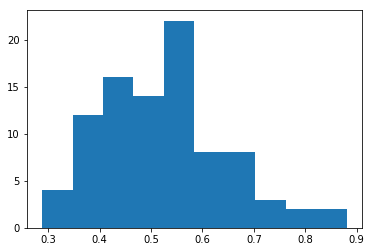

In [9]:
plt.hist(belief['strength'])